ValueError: Can not reset the axes.  You are probably trying to re-use an artist in more than one Axes which is not supported

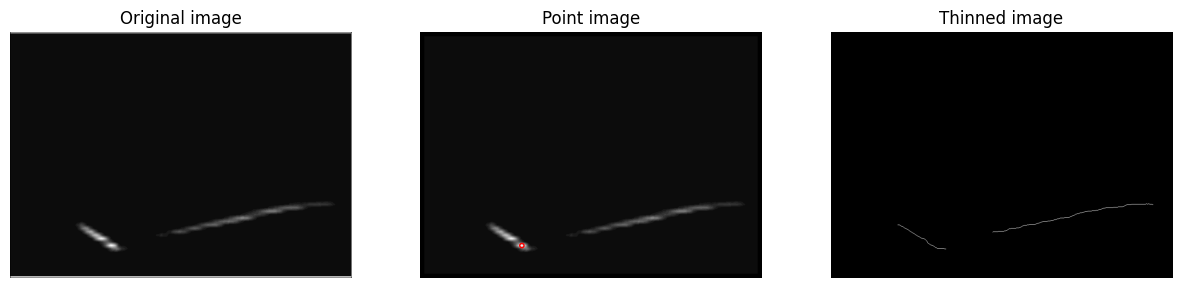

In [13]:
from skimage.morphology import skeletonize
from skimage.measure import LineModelND, ransac
from skimage.color import rgb2gray
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from src.openImage import openImage
from skimage.draw import disk
from scipy.ndimage import convolve


# Remove small shapes.
def cleanNoise(image, min_size_threshold=100):

    # Apply a different label for each shape.
    labeled_image, num_labels = ndimage.label(image)

    # Count the size of each labes which is the size of each shape. Remember to address the fact that 0 is not a real label and is background.
    sizes = np.bincount(labeled_image.ravel())

    # Exclude the background label (0) from the sizes array.
    sizes[0] = 0

    # Remove small connected components
    filtered_image = np.where(sizes[labeled_image] < min_size_threshold, 0, 1)

    return filtered_image

def cutTenPixels(data):

    height, width= data.shape

    # Set the border pixels to 0
    data[:10, :] = 0  # Top border
    data[height-10:, :] = 0  # Bottom border
    data[:, :10] = 0  # Left border
    data[:, width-10:] = 0  # Right border

    return data

def perpendicular_distance(point, slope, intercept):
            x, y = point
            return np.abs(slope * x - y + intercept) / np.sqrt(slope**2 + 1)

def filterOutliers(outliers, points, slope, intercept, distance_threshold):

    # Calculate perpendicular distance for all points
    distances = np.array([perpendicular_distance(point, slope, intercept) for point in points])

    # Exclude points within the set distance from the line
    filtered_outliers = np.logical_and(outliers, distances > distance_threshold)

    return filtered_outliers
    


def fitImage(path_and_name_input, path_and_name_output=None):


    ################### PARAMETERS TO BE CHANGED ###################
    circle_radius = 5
    ################################################################

    test_image = openImage(path_and_name_input)
    test_image.readImage()

    original_image = test_image.m_data

    # Black and white
    test_image.m_data = rgb2gray(test_image.m_data)

    #########################################
    ########### FOR WHITE BORDER ############
    test_image.m_data = cutTenPixels(test_image.m_data)
    #########################################
    #########################################

    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(original_image)
    ax[0].set_title('Original image')
    ax[0].set_axis_off()

    ax[1].imshow(test_image.m_data, cmap=cm.gray)
    ax[1].set_title('Point image')
    ax[1].set_axis_off()

    ######Actual calculation######
    ##############################

    """ max_avg_value = 0
    best_circle = None

    # Iterate over possible circle positions
    for y in range(circle_radius, test_image.m_data.shape[0] - circle_radius):
        for x in range(circle_radius, test_image.m_data.shape[1] - circle_radius):
            # Get pixel coordinates inside the circle
            rr, cc = disk((y, x), circle_radius, shape=test_image.m_data.shape)

            # Calculate average pixel value inside the circle
            avg_value = np.mean(test_image.m_data[rr, cc])

            # Update best circle if a higher average value is found
            if avg_value > max_avg_value:
                max_avg_value = avg_value
                best_circle = (y, x) """
    
    # Create a circular mask
    rr, cc = disk((circle_radius, circle_radius), circle_radius)
    mask = np.zeros((2 * circle_radius + 1, 2 * circle_radius + 1))
    mask[rr, cc] = 1

    # Convolve the image with the circular mask to get the sum of pixel values
    sum_values = convolve(test_image.m_data, mask, mode='constant', cval=0.0)

    # Create a circular mask with ones to count the number of pixels in the circle
    count_mask = np.ones_like(mask)
    count_values = convolve(np.ones_like(test_image.m_data), count_mask, mode='constant', cval=0.0)

    # Calculate the average pixel values
    avg_values = sum_values / count_values

    # Find the position with the highest average value
    best_position = np.unravel_index(np.argmax(avg_values), avg_values.shape)

    ##############################
    ##############################

    circle = plt.Circle((best_position[1], best_position[0]), circle_radius, color='red', fill=False)
    ax[1].add_patch(circle)


    #See how it works with skeletonize
    test_image.m_data = np.where(test_image.m_data < 0.1, 0, 1)
    test_image.m_data = cleanNoise(test_image.m_data, 100)
    test_image.m_data = skeletonize(test_image.m_data)

    ax[2].imshow(test_image.m_data, cmap=cm.gray)
    ax[2].set_title('Thinned image')
    ax[2].set_axis_off()

    skel_circle = plt.Circle((best_position[1], best_position[0]), circle_radius, color='red', fill=False)
    ax[2].add_patch(skel_circle)


    plt.tight_layout()
    # plt.show()
    plt.savefig(path_and_name_output)







# Make sure the dirs exist befoe calling the function. Don't have time to make sure in code.
#image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages2/"
#image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages_bw_fpn_only/"
image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/BAD_cleanimages_bw_fpn_and_smooth/"

image_list = ["CoBo_2018-06-20T10-51-39.459_0000/25",
              "CoBo_2018-06-20T10-51-39.459_0002/511",
              "CoBo_2018-06-20T10-51-39.459_0002/672",
              "CoBo_2018-06-20T10-51-39.459_0002/1019",
              "CoBo_2018-06-20T10-51-39.459_0003/1319",
              "CoBo_2018-06-20T10-51-39.459_0003/1428",
              "CoBo_2018-06-20T10-51-39.459_0004/114",
              "CoBo_2018-06-20T10-51-39.459_0004/319",
              "CoBo_2018-06-20T10-51-39.459_0004/417",
              "CoBo_2018-06-20T10-51-39.459_0004/448",
              "CoBo_2018-06-20T10-51-39.459_0004/1456",
              "CoBo_2018-06-20T10-51-39.459_0004/1596",
              "CoBo_2018-06-20T10-51-39.459_0004/1725",
              "CoBo_2018-06-20T10-51-39.459_0005/477",
              "CoBo_2018-06-20T10-51-39.459_0005/677",
              "CoBo_2018-06-20T10-51-39.459_0005/1113",
              "CoBo_2018-06-20T10-51-39.459_0005/1190",
              "CoBo_2018-06-20T10-51-39.459_0005/1311",
              "CoBo_2018-06-20T10-51-39.459_0005/1843"]


image_suffix_list = ["_u.png", "_v.png", "_w.png"]


output_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/fittedimages2/"


for image in image_list:
    for suffix in image_suffix_list:
        fitImage((image_path + image + suffix), (output_path + image + suffix))